In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

# Check if GPU is available
print("Is GPU available:", tf.test.is_gpu_available())

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True


In [3]:
import gc

tf.keras.backend.clear_session()
gc.collect()


0

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Optionally limit GPU memory
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)]  # 3GB limit
            )
    except RuntimeError as e:
        print(e)

In [5]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [6]:
dataset_path = "/Dataset"

In [7]:
def get_paths(dataset_path):
    classes =[]
    class_paths= []

    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)

        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)

                classes.append(label)
                class_paths.append(image_path)


    df = pd.DataFrame({
        'Class Path': class_paths,
        'Class': classes
    })

    return df


In [8]:
train_df = get_paths("Dataset/Training")
print(train_df)

                                     Class Path      Class
0      Dataset/Training\glioma\Tr-glTr_0000.jpg     glioma
1      Dataset/Training\glioma\Tr-glTr_0001.jpg     glioma
2      Dataset/Training\glioma\Tr-glTr_0002.jpg     glioma
3      Dataset/Training\glioma\Tr-glTr_0003.jpg     glioma
4      Dataset/Training\glioma\Tr-glTr_0004.jpg     glioma
...                                         ...        ...
5707  Dataset/Training\pituitary\Tr-pi_1452.jpg  pituitary
5708  Dataset/Training\pituitary\Tr-pi_1453.jpg  pituitary
5709  Dataset/Training\pituitary\Tr-pi_1454.jpg  pituitary
5710  Dataset/Training\pituitary\Tr-pi_1455.jpg  pituitary
5711  Dataset/Training\pituitary\Tr-pi_1456.jpg  pituitary

[5712 rows x 2 columns]


In [9]:
test_df = get_paths("Dataset/Testing")
test_df

,Class Path,Class
0,Dataset/Testing\glioma\Te-glTr_0000.jpg,glioma
1,Dataset/Testing\glioma\Te-glTr_0001.jpg,glioma
2,Dataset/Testing\glioma\Te-glTr_0002.jpg,glioma
3,Dataset/Testing\glioma\Te-glTr_0003.jpg,glioma
4,Dataset/Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Dataset/Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,Dataset/Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,Dataset/Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,Dataset/Testing\pituitary\Te-pi_0298.jpg,pituitary


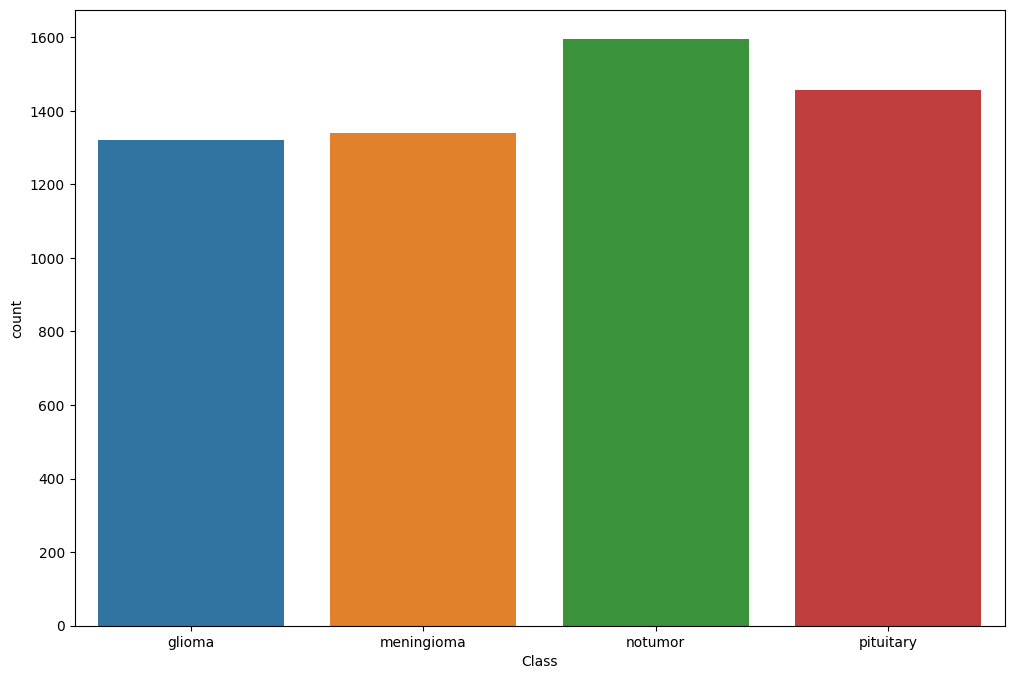

In [10]:
plt.figure(figsize=(12,8))
ax = sns.countplot(data=train_df , x=train_df['Class'])

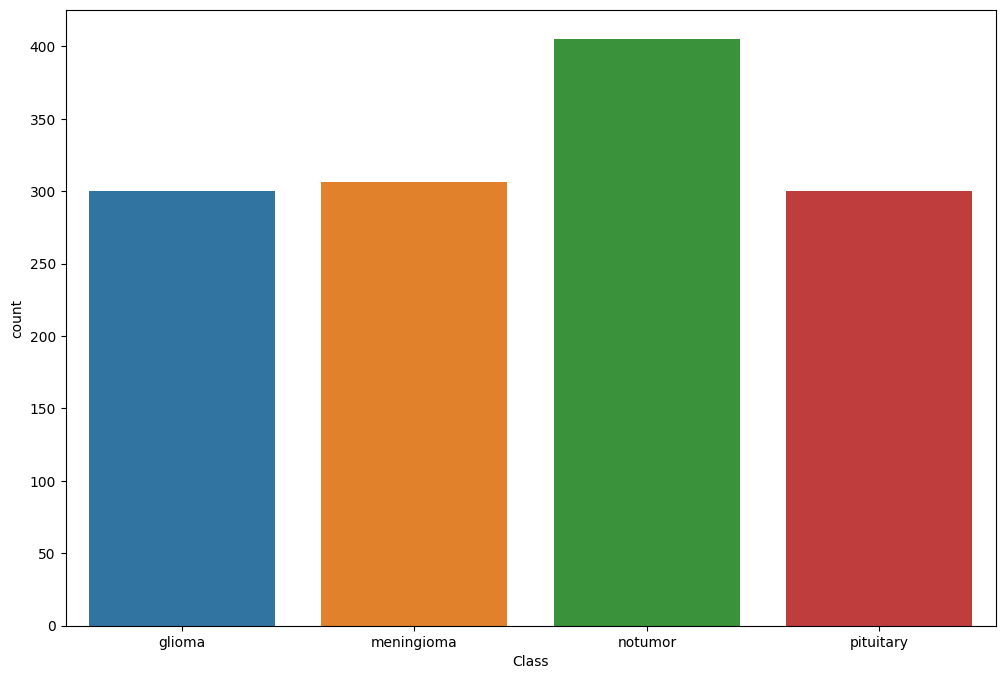

In [11]:
plt.figure(figsize=(12,8))
ax = sns.countplot(data=test_df , x=test_df['Class'])

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
valid_df , test_df = train_test_split(test_df , train_size=0.5, stratify=test_df['Class'])
valid_df

,Class Path,Class
33,Dataset/Testing\glioma\Te-gl_0033.jpg,glioma
880,Dataset/Testing\notumor\Te-no_0274.jpg,notumor
991,Dataset/Testing\notumor\Te-no_0385.jpg,notumor
693,Dataset/Testing\notumor\Te-no_0087.jpg,notumor
305,Dataset/Testing\meningioma\Te-meTr_0005.jpg,meningioma
...,...,...
386,Dataset/Testing\meningioma\Te-me_0086.jpg,meningioma
516,Dataset/Testing\meningioma\Te-me_0216.jpg,meningioma
926,Dataset/Testing\notumor\Te-no_0320.jpg,notumor
1201,Dataset/Testing\pituitary\Te-pi_0190.jpg,pituitary


In [14]:
test_df

,Class Path,Class
716,Dataset/Testing\notumor\Te-no_0110.jpg,notumor
375,Dataset/Testing\meningioma\Te-me_0075.jpg,meningioma
908,Dataset/Testing\notumor\Te-no_0302.jpg,notumor
333,Dataset/Testing\meningioma\Te-me_0033.jpg,meningioma
519,Dataset/Testing\meningioma\Te-me_0219.jpg,meningioma
...,...,...
447,Dataset/Testing\meningioma\Te-me_0147.jpg,meningioma
544,Dataset/Testing\meningioma\Te-me_0244.jpg,meningioma
1268,Dataset/Testing\pituitary\Te-pi_0257.jpg,pituitary
1056,Dataset/Testing\pituitary\Te-pi_0045.jpg,pituitary


In [ ]:
batch_size =8

In [16]:
img_size = (160,160)

In [17]:
image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8 ,1.2))

In [27]:
train_gen = image_generator.flow_from_dataframe(
    train_df,
    x_col ='Class Path',
    y_col ='Class',
    target_size=img_size,  
    batch_size=batch_size,          
    class_mode='categorical'
)

Found 5712 validated image filenames belonging to 4 classes.


In [28]:
valid_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col ='Class Path',
    y_col ='Class',
    target_size=img_size,  
    batch_size=batch_size,          
    class_mode='categorical'
)


Found 655 validated image filenames belonging to 4 classes.


In [29]:
test_gen = test_gen.flow_from_dataframe(test_df , x_col ='Class Path' , y_col='Class' , bath_size=batch_size, target_size =img_size, shuffle=False)

Found 656 validated image filenames belonging to 4 classes.


In [30]:
from PIL import Image

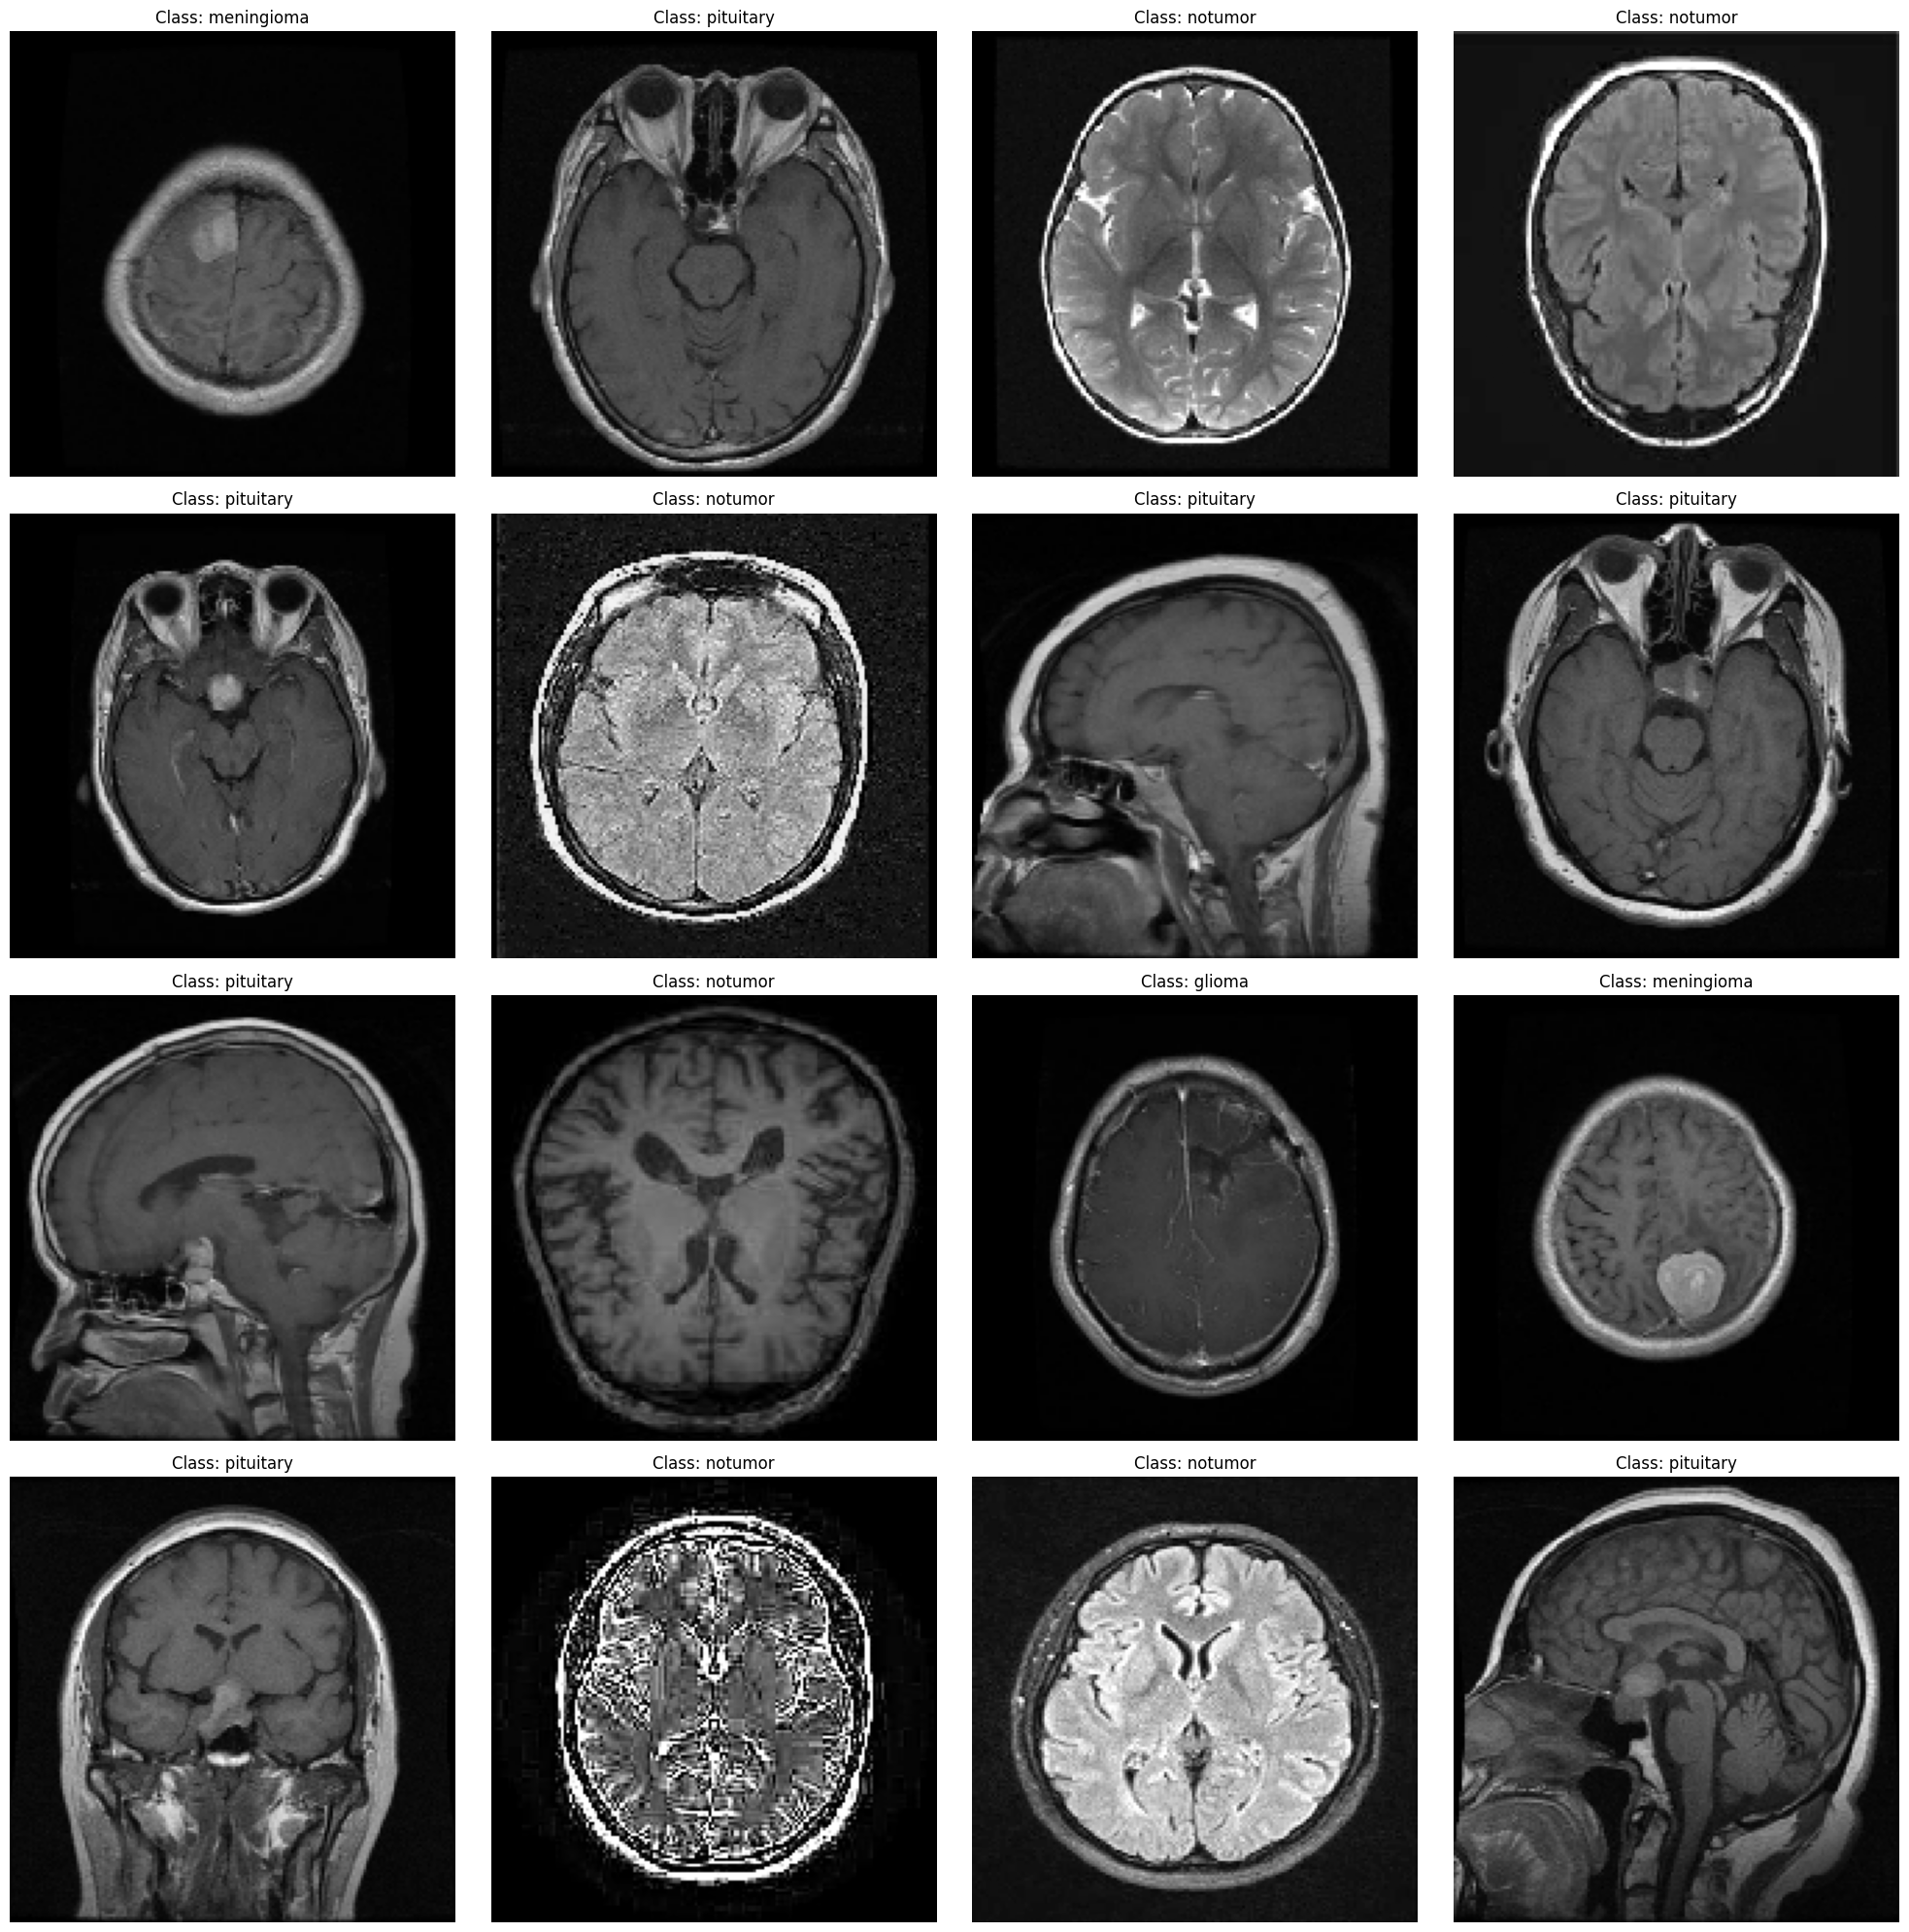

In [31]:
plt.figure(figsize = (20,20))
for i in range(16):
    plt.subplot(4,4, i+1)
    batch = next(train_gen)
    image =batch[0][0]
    label = batch[1][0]
    plt.imshow(image)

    class_index = np.argmax(label)
    class_names = list(train_gen.class_indices.keys())
    class_indices = list(train_gen.class_indices.values())

    index_position =class_indices.index(class_index)

    class_name= class_names[index_position]

    plt.title(f"Class: {class_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [32]:
img_shape =(160,160,3)

In [33]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

9406464/9406464 [==============================] - 1s 0us/step


In [36]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision() , Recall()]
)


In [37]:
try:
    history = model.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        workers=2,
        max_queue_size=8,
        verbose=1
    )
except tf.errors.ResourceExhaustedError:
    print("Memory error occurred. Trying with even smaller parameters...")
    # Fallback to even smaller configuration
    tf.keras.backend.clear_session()
    train_gen.batch_size = 8
    valid_gen.batch_size = 8
    history = model.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        workers=1,
        max_queue_size=4,
        verbose=1
    )

Epoch 1/5
357/357 [==============================] - 40s 102ms/step - loss: 0.0938 - accuracy: 0.9648 - precision: 0.9658 - recall: 0.9639 - val_loss: 0.1795 - val_accuracy: 0.9359 - val_precision: 0.9372 - val_recall: 0.9344
Epoch 2/5
357/357 [==============================] - 36s 100ms/step - loss: 0.0716 - accuracy: 0.9762 - precision: 0.9768 - recall: 0.9748 - val_loss: 0.2139 - val_accuracy: 0.9328 - val_precision: 0.9356 - val_recall: 0.9313
Epoch 3/5
357/357 [==============================] - 36s 101ms/step - loss: 0.0572 - accuracy: 0.9797 - precision: 0.9812 - recall: 0.9795 - val_loss: 0.1400 - val_accuracy: 0.9603 - val_precision: 0.9632 - val_recall: 0.9588
Epoch 4/5
357/357 [==============================] - 36s 99ms/step - loss: 0.0509 - accuracy: 0.9806 - precision: 0.9817 - recall: 0.9792 - val_loss: 0.1642 - val_accuracy: 0.9481 - val_precision: 0.9509 - val_recall: 0.9466
Epoch 5/5
357/357 [==============================] - 41s 115ms/step - loss: 0.0370 - accuracy: 0.

In [39]:
model.compile(
    Adamax(learning_rate= 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision() , Recall()]
)


In [40]:
try:
    history = model.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        workers=2,
        max_queue_size=8,
        verbose=1
    )
except tf.errors.ResourceExhaustedError:
    print("Memory error occurred. Trying with even smaller parameters...")
    # Fallback to even smaller configuration
    tf.keras.backend.clear_session()
    train_gen.batch_size = 8
    valid_gen.batch_size = 8
    history = model.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        workers=1,
        max_queue_size=4,
        verbose=1
    )

Epoch 1/5
357/357 [==============================] - 40s 103ms/step - loss: 0.0187 - accuracy: 0.9954 - precision_1: 0.9954 - recall_1: 0.9949 - val_loss: 0.1173 - val_accuracy: 0.9634 - val_precision_1: 0.9663 - val_recall_1: 0.9618
Epoch 2/5
357/357 [==============================] - 36s 100ms/step - loss: 0.0133 - accuracy: 0.9972 - precision_1: 0.9972 - recall_1: 0.9970 - val_loss: 0.1157 - val_accuracy: 0.9725 - val_precision_1: 0.9739 - val_recall_1: 0.9695
Epoch 3/5
357/357 [==============================] - 36s 100ms/step - loss: 0.0101 - accuracy: 0.9991 - precision_1: 0.9991 - recall_1: 0.9989 - val_loss: 0.1075 - val_accuracy: 0.9649 - val_precision_1: 0.9663 - val_recall_1: 0.9634
Epoch 4/5
357/357 [==============================] - 39s 109ms/step - loss: 0.0099 - accuracy: 0.9986 - precision_1: 0.9986 - recall_1: 0.9986 - val_loss: 0.1121 - val_accuracy: 0.9603 - val_precision_1: 0.9647 - val_recall_1: 0.9588
Epoch 5/5
357/357 [==============================] - 43s 119ms/s

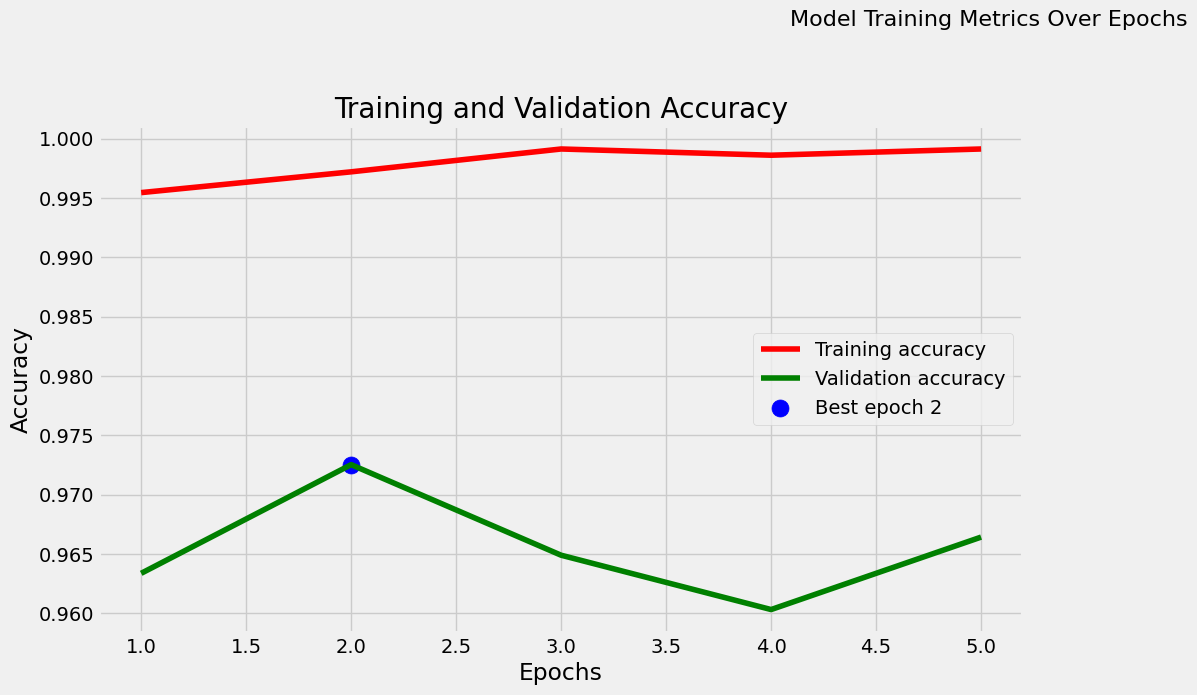

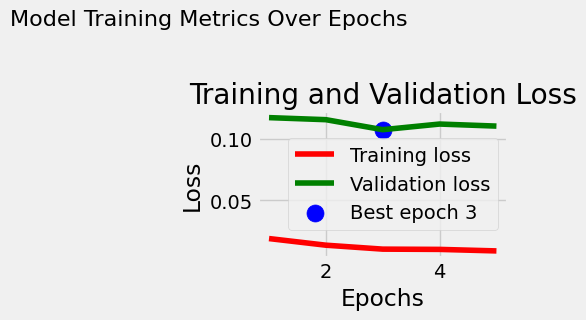

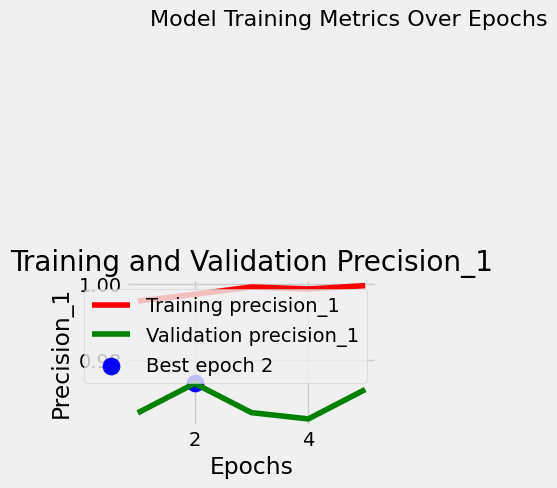

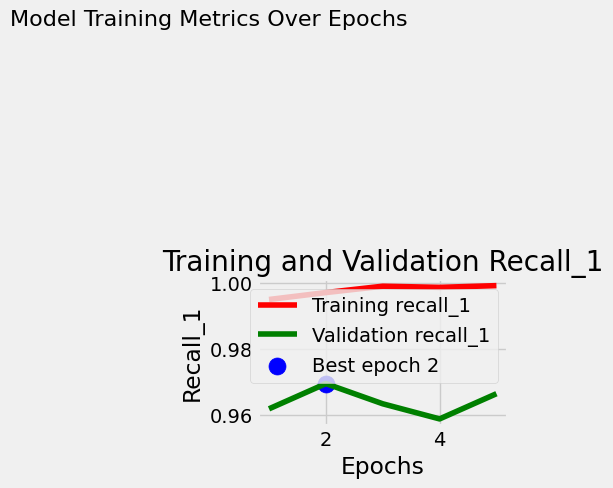

In [47]:
metrics = ['accuracy' , 'loss' , 'precision_1' , 'recall_1']
train_metrics = {m: history.history[m] for m in metrics}
valid_metrics = {m: history.history[f'val_{m}'] for m in metrics}

best_epochs ={}
best_values ={}

for m in metrics:
    if m == 'loss':
        idx =np.argmin(valid_metrics[m])
    else:
        idx = np.argmax(valid_metrics[m])
    best_epochs[m] = idx +1 
    best_values[m] = valid_metrics[m][idx]

plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')


for i, metric in enumerate(metrics, 1):
    plt.subplot(2,2, i)
    epochs = range(1, len(train_metrics[metric]) + 1)
    plt.suptitle('Model Training Metrics Over Epochs', fontsize=16,  y=1.02)
    plt.plot(epochs, train_metrics[metric], 'r' , label=f'Training {metric}')
    plt.plot(epochs, valid_metrics[metric], 'g' , label=f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric] , s=150, c='blue',label=f'Best epoch {best_epochs[metric]}')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [49]:
train_score = model.evaluate(train_gen , verbose=1)
valid_score = model.evaluate(valid_gen , verbose=1)
test_score = model.evaluate(test_gen , verbose=1)

print(f'Train Accuracy: {train_score[1]*100:.2f}%')
print(f'Train Loss: {train_score[0]:.4f}')
print(f'\n\n Validation Accuracy: {valid_score[1]*100:.2f}%')
print(f'Validation Loss: {valid_score[0]:.4f}')
print(f'\n\n Test Accuracy: {test_score[1]*100:.2f}%')
print(f'Test Loss: {test_score[0]:.4f}')

21/21 [==============================] - 3s 117ms/step - loss: 0.1274 - accuracy: 0.9527 - precision_1: 0.9527 - recall_1: 0.9527
Train Accuracy: 99.96%
Train Loss: 0.0076


 Validation Accuracy: 96.34%
Validation Loss: 0.1199


 Test Accuracy: 95.27%
Test Loss: 0.1274


21/21 [==============================] - 3s 129ms/step


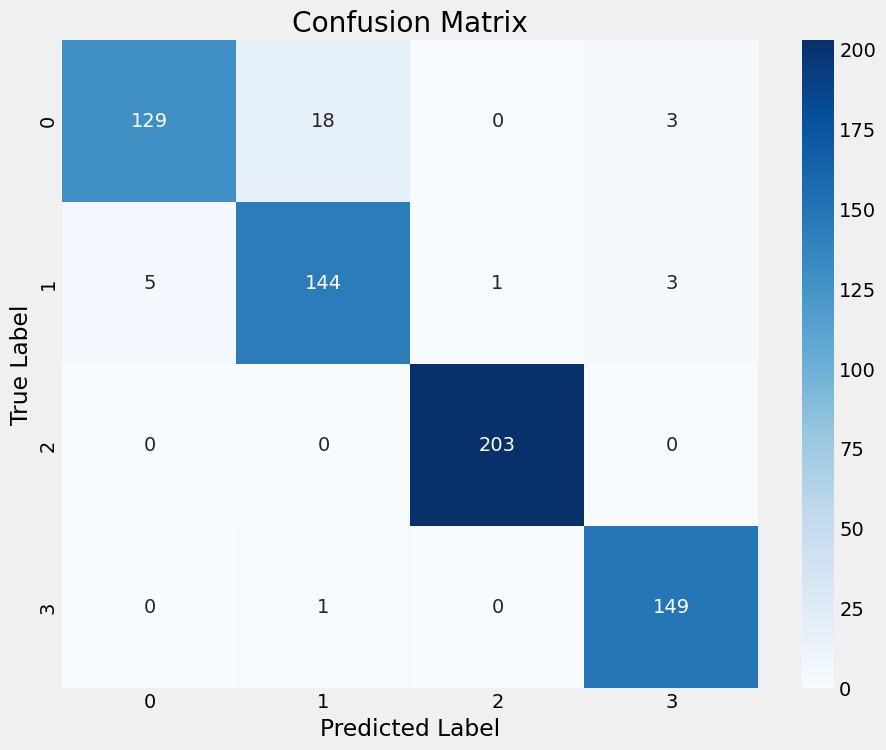

In [51]:
pred = model.predict(test_gen)
y_pred =np.argmax(pred , axis =1)

class_dict= {
    0:'glioma',
    1: 'meningioma',
    2:'no_tumor',
    3: 'pituitary'

}

conf_mat =confusion_matrix(test_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()





In [54]:
from PIL import Image

def predict(img_path: str) -> None:
    labels = list(class_dict.keys())

   
    plt.figure(figsize=(6, 8))

    img = Image.open(img_path)
    resized_img = img.resize((160, 160))
    img_array = np.asarray(resized_img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0


    predictions = model.predict(img_array)
    probabilities = list(predictions[0])

    predicted_class_idx = np.argmax(probabilities)
    predicted_class = class_dict[predicted_class_idx]

   
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.title(f"Input MRI Image\nPredicted: {predicted_class}")


    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probabilities)
    plt.xlabel("Probability", fontsize=15)
    plt.title("Class Probabilities")

    ax = plt.gca()
    ax.bar_label(bars, fmt="%.2f")

    plt.tight_layout()
    plt.show()

    print(f"\nPredicted tumor type: {predicted_class}")

1/1 [==============================] - 1s 1s/step


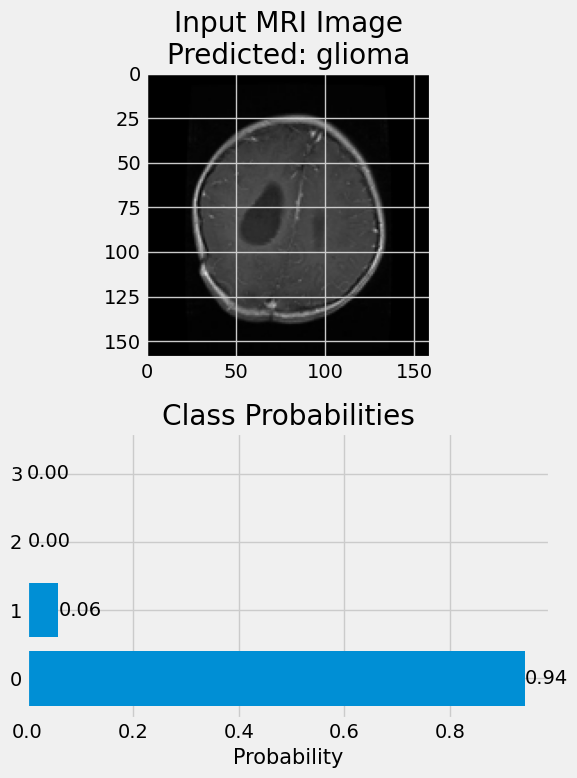


Predicted tumor type: glioma


In [55]:
predict("Dataset/Testing/glioma/Te-gl_0018.jpg")

1/1 [==============================] - 0s 90ms/step


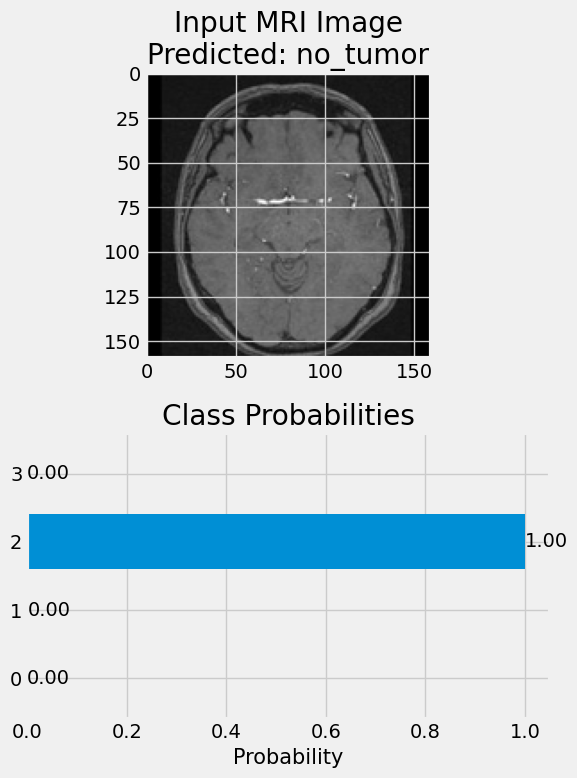


Predicted tumor type: no_tumor


In [59]:
predict("Dataset/Testing/notumor/Te-no_0017.jpg")

In [60]:
model.save("Model.h5")

In [61]:
from threading import Thread
from pyngrok import ngrok

In [67]:
from dotenv import load_dotenv

load_dotenv()
ngrok_token = os.getenv('NGROK_AUTH_TOKEN')

# Set auth token
ngrok.set_auth_token(ngrok_token)

In [86]:
def run_streamlit():
    os.system("streamlit run /app.py --server.port 8501")

In [87]:
thread = Thread(target=run_streamlit)
thread.start()

In [90]:
public_url= ngrok.connect(addr='8501', proto='http', bind_tls=True)

print("Public URL:" , public_url)


Public URL: NgrokTunnel: "https://a99f-2603-6010-1f0-4500-b03b-17e7-6acb-f2b6.ngrok-free.app" -> "http://localhost:8501"


In [89]:
tunnels =ngrok.get_tunnels()
for tunnel in tunnels:
    print(f"Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
    ngrok.disconnect(tunnel.public_url)

Closing tunnel: https://9c01-2603-6010-1f0-4500-b03b-17e7-6acb-f2b6.ngrok-free.app -> http://localhost:8501
